# Image Classification Batch Inference with PyTorch

<a href="https://www.anyscale.com/ray-on-anyscale?utm_source=ray_docs&utm_medium=docs&utm_campaign=image-classification-batch-inference-with-pytorch&redirectTo=/v2/template-preview/ray-data-batch-image-classification">
    <img src="../../_static/img/run-on-anyscale.svg" alt="try-anyscale-quickstart-image-classification-batch-inference-with-pytorch">
</a>
<br></br>

In this example, we will introduce how to use [Ray Data](data) for **large-scale batch inference with multiple GPU workers.**

In particular, we will:
- Load the Imagenette dataset from an S3 bucket and create a Ray Dataset.
- Load a pretrained ResNet model.
- Use Ray Data to preprocess the dataset and do model inference parallelizing across multiple GPUs
- Evaluate the predictions and save results to S3/local disk.

This example will still work even if you do not have GPUs available, but overall performance will be slower.

**See [this guide on batch inference](batch_inference_home) for tips and troubleshooting when adapting this example to use your own model and dataset!**

To run this example, you will need the following packages:

In [ ]:
!pip install -q "ray[data]" torch torchvision

## Step 1: Reading the Dataset from S3

[Imagenette](https://github.com/fastai/imagenette) is a subset of Imagenet with 10 classes. We have this dataset hosted publicly in an S3 bucket. Since we are only doing inference here, we load in just the validation split.

Here, we use {meth}`ray.data.read_images <ray.data.read_images>` to load the validation set from S3. Ray Data also supports reading from a variety of other [datasources and formats](loading_data).

In [1]:
import ray

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"

ds = ray.data.read_images(s3_uri, mode="RGB")
ds


2023-06-27 23:23:57,184	INFO worker.py:1452 -- Connecting to existing Ray cluster at address: 10.0.5.141:6379...
2023-06-27 23:23:57,228	INFO worker.py:1627 -- Connected to Ray cluster. View the dashboard at https://session-kncgqf3p7w2j7qcsnz2safl4tj.i.anyscaleuserdata-staging.com 
2023-06-27 23:23:57,243	INFO packaging.py:347 -- Pushing file package 'gcs://_ray_pkg_32ef287a3a39e82021e70d2413880a69.zip' (4.49MiB) to Ray cluster...
2023-06-27 23:23:57,257	INFO packaging.py:360 -- Successfully pushed file package 'gcs://_ray_pkg_32ef287a3a39e82021e70d2413880a69.zip'.
2023-06-27 23:23:59,629	WARNING dataset.py:253 -- Important: Ray Data requires schemas for all datasets in Ray 2.5. This means that standalone Python objects are no longer supported. In addition, the default batch format is fixed to NumPy. To revert to legacy behavior temporarily, set the environment variable RAY_DATA_STRICT_MODE=0 on all cluster processes.

Learn more here: https://docs.ray.io/en/master/data/faq.html#migrat

Dataset(
   num_blocks=200,
   num_rows=9469,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

Inspecting the schema, we can see that there is 1 column in the dataset containing the images stored as Numpy arrays.

In [2]:
ds.schema()


Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

## Step 2: Inference on a single batch

Next, we can do inference on a single batch of data, using a pre-trained ResNet152 model and following [this PyTorch example](https://pytorch.org/vision/main/models.html#classification). 

Let’s get a batch of 10 from our dataset. Each image in the batch is represented as a Numpy array.

In [3]:
single_batch = ds.take_batch(10)


We can visualize 1 image from this batch.

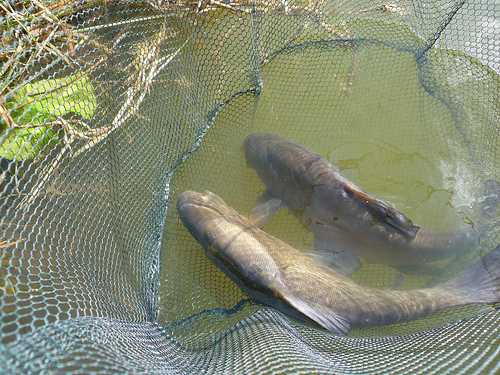

In [4]:
from PIL import Image

img = Image.fromarray(single_batch["image"][0])
img


Now, let’s download a pre-trained PyTorch Resnet model and get the required preprocessing transforms to preprocess the images prior to prediction.

In [5]:
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet152_Weights.IMAGENET1K_V1

# Load the pretrained resnet model and move to GPU if one is available.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=weights).to(device)
model.eval()

imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])


Then, we apply the transforms to our batch of images and pass the batch to the model for inference, making sure to use the GPU device for inference.

We can see that most of the images in the batch have been correctly classified as "tench", which is a type of fish.

In [6]:
transformed_batch = [transform(image) for image in single_batch["image"]]
with torch.inference_mode():
    prediction_results = model(torch.stack(transformed_batch).to(device))
    classes = prediction_results.argmax(dim=1).cpu()

del model  # Free up GPU memory

labels = [weights.meta["categories"][i] for i in classes]
labels


['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'bittern',
 'tench']

## Step 3: Scaling up to the full Dataset with Ray Data

By using Ray Data, we can apply the same logic in the previous section to scale up to the entire dataset, leveraging all the GPUs in our cluster.

### Preprocessing

First let's convert the preprocessing code to Ray Data. We'll package the preprocessing code within a `preprocess_image` function. This function should take only one argument, which is a dict that contains a single image in the dataset, represented as a numpy array. We use the same `transform` function that was defined above and store the transformed image in a new `transformed_image` field.

Note that typically, we would only want to keep the transformed image for efficiency purposes. However, for the sake of this tutorial, we are keeping the original image as well so that we can display them with the predictions at the end.

In [9]:
import numpy as np
from typing import Dict

def preprocess_image(row: Dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }


Then we use the {meth}`~ray.data.Dataset.map` method to apply the function to the whole dataset row by row. We use this instead of {meth}`~ray.data.Dataset.map_batches` because the `torchvision` transforms must be applied one image at a time, due to the dataset containing images of different sizes.

By using Ray Data's {meth}`~ray.data.Dataset.map` method, we can scale out the preprocessing to utilize all the resources in our Ray cluster.

"Note: the {meth}`~ray.data.Dataset.map` method is lazy. It won't perform execution until we consume the results with methods like {meth}`~ray.data.Dataset.iter_batches()` or {meth}`~ray.data.Dataset.take()`."

In [10]:
transformed_ds = ds.map(preprocess_image)


2023-06-27 23:25:59,387	WARNING dataset.py:4384 -- The `map`, `flat_map`, and `filter` operations are unvectorized and can be very slow. If you're using a vectorized transformation, consider using `.map_batches()` instead.


### Model Inference

Next, let's convert the model inference part. Compared with preprocessing, model inference has 2 differences:
1. Model loading and initialization is usually expensive. 
2. Model inference can be optimized with hardware acceleration if we process data in batches. Using larger batches improves GPU utilization and the overall runtime of the inference job.

Thus, we convert the model inference code to the following `ResnetModel` class. In this class, we put the expensive model loading and initialization code in the `__init__` constructor, which will run only once. And we put the model inference code in the `__call__` method, which will be called for each batch.

The `__call__` method takes a batch of data items, instead of a single one. In this case, the batch is a dict that has the `"transformed_image"` key populated by our preprocessing step, and the corresponding value is a Numpy array of images represented in `np.ndarray` format. We reuse the same inferencing logic from step 2.

In [11]:
from typing import Dict
import numpy as np
import torch


class ResnetModel:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a PyTorch tensor.
        # Move the tensor batch to GPU if available.
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }


Then we use the {meth}`~ray.data.Dataset.map_batches` API to apply the model to the whole dataset:

- The first parameter of `map_batches` is the user-defined function (UDF), which can either be a function or a class. Because this case uses a class, the UDF runs as long-running [Ray actors](actor-guide). For class-based UDFs, use the `concurrency` argument to specify the number of parallel actors.
- The `num_gpus` argument specifies the number of GPUs needed for each `ResnetModel` instance. In this case, we want 1 GPU for each model replica. If you are doing CPU inference, you can remove the `num_gpus=1`.
- The `batch_size` argument indicates the number of images in each batch. See the Ray dashboard
for GPU memory usage to experiment with the `batch_size` when using your own model and dataset.
You should aim to max out the batch size without running out of GPU memory. You may need to reduce this number to run this locally.



In [12]:
predictions = transformed_ds.map_batches(
    ResnetModel,
    concurrency=4,  # Use 4 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica.
    batch_size=720,  # Use the largest batch size that can fit on our GPUs.
)


### Verify and Save Results

Let's take a small batch of predictions and verify the results.

In [13]:
prediction_batch = predictions.take_batch(5)


2023-06-27 23:26:04,893	INFO streaming_executor.py:91 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map] -> ActorPoolMapOperator[MapBatches(ResnetModel)]
2023-06-27 23:26:04,894	INFO streaming_executor.py:92 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-06-27 23:26:04,895	INFO streaming_executor.py:94 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-06-27 23:26:04,950	INFO actor_pool_map_operator.py:114 -- MapBatches(ResnetModel): Waiting for 4 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-06-27 23:26:29,120	INFO streaming_executor.py:149 -- Shutting down <StreamingExecutor(Thread-36, started daemon 140560158410496)>.
2023-06-27 23:26:29,335	WARNING actor_pool_map_operator.py:264 -- To ensure full parallelization across an actor pool of size 4, the specified batch size should be at most 360. Your configured batch size for this operator was 720.


We see that all the images are correctly classified as "tench", which is a type of fish.

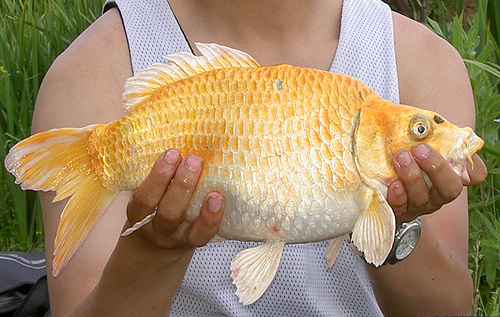

Label:  tench


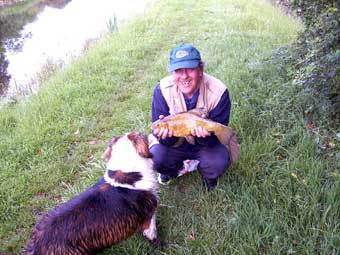

Label:  tench


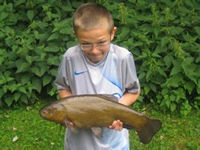

Label:  tench


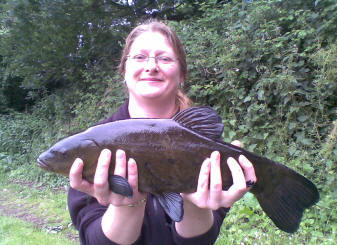

Label:  tench


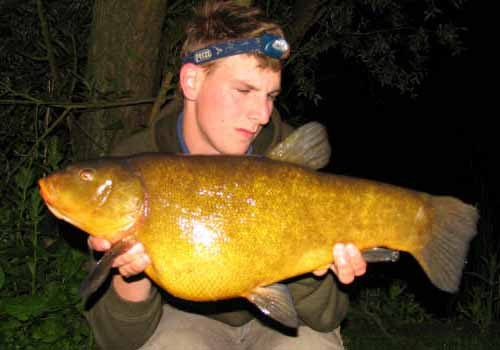

Label:  tench


In [14]:
from PIL import Image

for image, prediction in zip(
    prediction_batch["original_image"], prediction_batch["predicted_label"]
):
    img = Image.fromarray(image)
    display(img)
    print("Prediction: ", prediction)


If the samples look good, we can proceed with saving the results to external storage (for example, local disk or cloud storage such as AWS S3). See [the guide on saving data](saving-data) for all supported storage and file formats.


In [15]:
import tempfile

temp_dir = tempfile.mkdtemp()

# First, drop the original images to avoid them being saved as part of the predictions.
# Then, write the predictions in parquet format to a path with the `local://` prefix
# to make sure all results get written on the head node.
predictions.drop_columns(["original_image"]).write_parquet(f"local://{temp_dir}")
print(f"Predictions saved to `{temp_dir}`!")


2023-06-27 23:26:38,105	INFO streaming_executor.py:91 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map] -> ActorPoolMapOperator[MapBatches(ResnetModel)] -> TaskPoolMapOperator[MapBatches(<lambda>)] -> TaskPoolMapOperator[Write]
2023-06-27 23:26:38,106	INFO streaming_executor.py:92 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-06-27 23:26:38,106	INFO streaming_executor.py:94 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-06-27 23:26:38,141	INFO actor_pool_map_operator.py:114 -- MapBatches(ResnetModel): Waiting for 4 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

2023-06-27 23:27:27,855	INFO streaming_executor.py:149 -- Shutting down <StreamingExecutor(Thread-74, stopped daemon 140560149755648)>.


Predictions saved to `/tmp/tmp0y52g_f5`!
